In [1]:
%run ../../_setup.py

import numpy as np
import xarray as xr

import pyproj

from OceanPy.kinematics import gradient_wind_from_ssh
from gsw import f

from stsci.convolve import boxcar

import matplotlib.pyplot as plt
import cmocean as cmo


## Strain-shear Okubu-Weiss parameter from SSH

In [2]:
# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')
ssh = xr.open_dataset(input_file)

# transform polar in cartesian coordinate system
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# select data range
west = 135 #137
south = -53.4 #-52.4
east = 149 #147
north = -47 #-48

# select time
timevoy = slice('1998-03-10', '1998-03-28')
# timevoy = slice('1998-08-15', '1998-10-15')

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north))


In [4]:
# notice: 'ugeos' and 'vgeos' are calculated within function, not taken from AVISO product
# TODO: check in gradient_wind_from_ssh the calculation of orientation, and compare with function gradient_balance_from_ssh
gw = gradient_wind_from_ssh(ssh, variables=('adt', 'ugos', 'vgos'), transform=UTM54)
loni, lati = gw.longitude.data, gw.latitude.data

lnln, ltlt = np.meshgrid(loni, lati)
xx, yy = pyproj.transform(WGS84, UTM54, lnln, ltlt)

/home/janjaapmeijer/Checkouts/OceanPy/kinematics.py:197: RuntimeWarning: divide by zero encountered in true_divide
  orientation = np.arctan(vgeos / ugeos)
/home/janjaapmeijer/Checkouts/OceanPy/kinematics.py:203: RuntimeWarning: invalid value encountered in sqrt
  root = np.sqrt(((fcor**2 * Rcurv**2) / 4) + (fcor * Rcurv * Vgeos))


In [5]:
# determine planetary vorticity
fcor = xr.DataArray(f(ltlt), dims=['latitude', 'longitude'], coords=[ssh.latitude, ssh.longitude])
beta = np.gradient(fcor)[0] / np.gradient(yy)[0]
# fcorH = f(ltltH)

# ageostrophic velocities
ua, va = (gw.ugrad - gw.ugeos), (gw.vgrad - gw.vgeos)
grid_point = (3, 3)

# calculate flow speed, relative vorticity and divergence
zeta = np.ma.masked_all(gw.Vgrad.shape)
# dzetadx, dzetady = zeta.copy(), zeta.copy()
sn, ss = zeta.copy(), zeta.copy()
divgeos, dwdz  = zeta.copy(), zeta.copy()
fdwdz, betavg, ugradzeta = zeta.copy(), zeta.copy(), zeta.copy()
for t in range(len(gw.time)):
#     dvdx = boxcar(np.gradient(gw.vgrad[t,])[1] / np.gradient(xx)[1], grid_point)
#     dudy = boxcar(np.gradient(gw.ugrad[t,])[0] / np.gradient(yy)[0], grid_point)
    
#     dudx = boxcar(np.gradient(gw.ugrad[t,])[1] / np.gradient(xx)[1], grid_point)
#     dvdy = boxcar(np.gradient(gw.vgrad[t,])[0] / np.gradient(yy)[0], grid_point)
    
    dvdx = boxcar(np.gradient(gw.vgeos[t,])[1] / np.gradient(xx)[1], grid_point)
    dudy = boxcar(np.gradient(gw.ugeos[t,])[0] / np.gradient(yy)[0], grid_point)
    
    dudx = boxcar(np.gradient(gw.ugeos[t,])[1] / np.gradient(xx)[1], grid_point)
    dvdy = boxcar(np.gradient(gw.vgeos[t,])[0] / np.gradient(yy)[0], grid_point)

    # (gradients of) relative vorticity
    zeta[t,] = dvdx - dudy
    dzetadx = boxcar(np.gradient(zeta[t,])[1] / np.gradient(xx)[1], grid_point)
    dzetady = boxcar(np.gradient(zeta[t,])[0] / np.gradient(yy)[0], grid_point)
    
    # normal and shear components of strain
    sn[t,] = dudx - dvdy
    ss[t,] = dvdx + dudy

# Save in dataarray,
# TODO: save in DataSet
zeta = xr.DataArray(zeta, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])

# calculate vortivity budget terms
ugradzeta = xr.DataArray(ugradzeta, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
betavg = xr.DataArray(betavg, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
fdwdz = xr.DataArray(fdwdz, dims=['time', 'longitude', 'latitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
                                                                                                       
# calculate Okubu-Weiss parameter
sn = xr.DataArray(sn, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
ss = xr.DataArray(ss, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])
OW = sn**2 + ss**2 - zeta**2
OW = xr.DataArray(OW, dims=['time', 'latitude', 'longitude'], coords=[ssh.time, ssh.latitude, ssh.longitude])


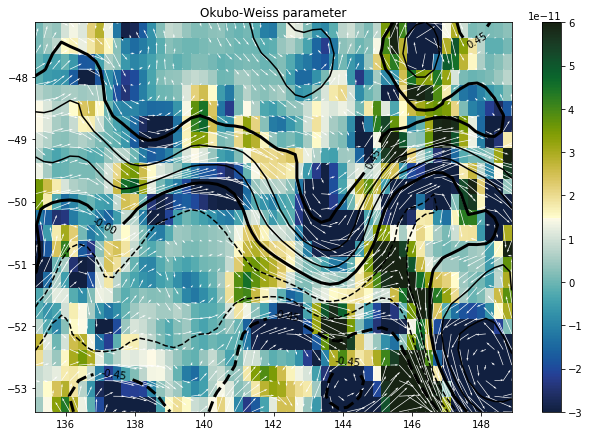

In [7]:
fig, ax = plt.subplots(figsize=(9, 6), sharex=True)
fig.tight_layout()

# plot relative vorticity field
# vmin, vmax = Wcenter + W0 - 1e-12, Wcenter + W0 + 1e-12
bounds = np.linspace(-0.45, 0.75, 9)
vmin, vmax = -3e-11, 6e-11
axis=0
pcol = ax.pcolor(loni, lati, OW.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.delta)
plt.colorbar(pcol)
ax.set_title('Okubo-Weiss parameter')

# for i in range(len(ax)):
    
# plot dynamic height contours
ct = ax.contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'), bounds, colors='k')
for ib, b in enumerate(bounds):
    if b in bounds[0::3]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=3)
ax.clabel(ct, bounds[0::3], inline=1, fontsize=10, fmt='%.2f')

quiv = ax.quiver(loni, lati, ssh.ugos.sel(time=timevoy).mean('time'), ssh.vgos.sel(time=timevoy).mean('time'), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='w')

#     # plot depth contours
#     ax[i].contourf(lonlonH, latlatH, dep, depths, 
#                        cmap=plt.cm.binary_r, alpha=0.3)
#     dc = ax[i].contour(lonlonH, latlatH, dep, depths, 
#                        colors='k', linewidths=0.2, linestyles='solid')
#     ax[i].clabel(dc, depths, inline=1, fontsize=8, fmt='%.0f')

# # plot observations domain
# ax.fill([138, 143.5, 143.5, 138], [-51.75, -51.75, -48.75, -48.75], 
#            facecolor='none', edgecolor='m', linewidth=3)

# # plot transects
# for transect in transects.keys():
#     istations = np.array(transects[transect]) - 1
#     ax.plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 'm.-')